In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { margin-left: 0 !important; width:100% !important; }</style>"))

In [99]:
import math
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches
import json
from types import SimpleNamespace
import cmath
import glob
import itertools

In [175]:
# example0:
# {
#   "EntryType":"EquivalentLoudnessMeasurement",
#   "Calibration":{
#     "HeadphoneFrequencyResponseHash":"eab807a5050b0087109ac1fd6fecbd09197a3dcd",
#     "FullScaleSineDBSPL":100
#   },
#   "Run":{
#     "ID":"1599737802659_2857050667"
#   },
#   "Evaluation":{
#     "ID":"1599738237070_2365796582",
#     "Frequency":697.9866246810275,
#     "Probe":{
#       "Type":"Noise",
#       "Params":{
#         "Level":-10,
#         "LowerLimit":966.84025,
#         "Onset":{
#           "Delay":0,
#           "Duration":0.1
#         },
#         "UpperLimit":1033.15975
#       }
#     },
#     "Combined":{
#       "Type":"Superposition",
#       "Params":[
#         {
#           "Params":{
#             "Level":-40,
#             "LowerLimit":966.84025,
#             "Onset":{
#               "Delay":0.5,
#               "Duration":0.1
#             },
#             "UpperLimit":1033.15975
#           },
#           "Type":"Noise"
#         },{
#           "Params":{
#             "Level":-20,
#             "LowerLimit":672.9766301106662,
#             "Onset":{
#               "Delay":0,
#               "Duration":0.1
#             },
#             "UpperLimit":722.9966192513888
#           },
#           "Type":"Noise"
#         }
#       ]
#     }
#   },
#   "Results":{
#     "ProbeGainForEquivalentLoudness":0.003107877399956887,
#     "ProbeDBSPLForEquivalentLoudness":39.84927756697657
#   }
# }
def experiment_result_to_example(js, car_fs_sine_level=100, window_size=2048, sample_rate=48000):
    exp = json.loads(js, object_hook=lambda o: SimpleNamespace(**o))
    if exp.EntryType != 'EquivalentLoudnessMeasurement':
        return None
    assert exp.Evaluation.Probe.Type == 'Noise'
    assert exp.Evaluation.Combined.Type == 'Superposition'
    for part in exp.Evaluation.Combined.Params:
        assert part.Type == 'Noise'
    assert exp.Results.ProbeGainForEquivalentLoudness > 0
    assert exp.Results.ProbeDBSPLForEquivalentLoudness != None
    assert exp.Calibration.FullScaleSineDBSPL > 0
        
    bin_width = sample_rate / window_size
    def add_noise(coeffs, lower_limit, upper_limit, total_power_db_fs):
        first_bin = int(np.floor(lower_limit/bin_width))
        last_bin = int(np.ceil(upper_limit/bin_width))
        noise_coeffs = (complex(0, 1) * np.random.normal(size=[last_bin-first_bin]) + 
                        np.random.normal(size=[last_bin-first_bin]))
        noise_power_db_fs = 10 * np.log10(np.sum(noise_coeffs ** 2))
        scale = 10 ** ((total_power_db_fs - noise_power_db_fs) / 20)
        noise_coeffs *= scale
        for bin_idx in range(first_bin, first_bin + 1):
            coeffs[bin_idx] += noise_coeffs[bin_idx - first_bin]
            coeffs[-bin_idx] += np.conjugate(coeffs[bin_idx])
    coeffs = np.zeros([window_size], dtype=np.complex64)
    for part in exp.Evaluation.Combined.Params:
        part_db_spl = exp.Calibration.FullScaleSineDBSPL + part.Params.Level
        part_db_fs = part_db_spl - car_fs_sine_level
        add_noise(coeffs, part.Params.LowerLimit, part.Params.UpperLimit, part_db_fs)
    
    relevant_bins = np.zeros([int(window_size/2)], dtype=np.complex64)
    first_relevant_bin = int(np.floor(exp.Evaluation.Probe.Params.LowerLimit/bin_width))
    last_relevant_bin = int(np.ceil(exp.Evaluation.Probe.Params.UpperLimit/bin_width))
    for bin_idx in range(first_relevant_bin, last_relevant_bin + 1):
        relevant_bins[bin_idx] = 1

    true_loudness = np.array([exp.Results.ProbeDBSPLForEquivalentLoudness], dtype=np.complex64)
    
    res = tf.concat([coeffs, true_loudness, relevant_bins], axis=0)
    return res

def load_examples(glb, car_fs_sine_level=100, window_size=2048, sample_rate=48000, batch_size=32, repeat=1):
    lines_iter = itertools.chain(*map(lambda f: open(f).readlines(), glob.glob(glb)))
    examples_iter = map(lambda l: experiment_result_to_example(l, car_fs_sine_level=car_fs_sine_level, window_size=window_size, sample_rate=sample_rate), lines_iter)
    filtered_iter = filter(lambda e: e != None, examples_iter)
    ds = tf.data.Dataset.from_tensor_slices(list(filtered_iter))
    input_true_ds = example_ds.map(lambda ex: (ex[:window_size], ex[window_size:]))
    repeated_ds = input_true_ds.repeat(repeat)
    batched_ds = repeated_ds.batch(batch_size)
    return batched_ds
            
def pz_plot():
    _, ax = plt.subplots(figsize=(4,4))
    ax.add_patch(patches.Circle((0,0),
                              radius=1,
                              fill=False,
                              color='black',
                              ls='solid',
                              alpha=0.1))
    ax.axvline(0, color='0.7')
    ax.axhline(0, color='0.7')
    ax.set_xlim((-1.1,1.1))
    ax.set_ylim((-1.1,1.1))
    return ax

class PZLayer(tf.keras.layers.Layer):
    def __init__(self, gain=complex(1.0, 0), poles=None, zeros=None, **kwargs):
        super(PZLayer, self).__init__(**kwargs)
        self._gain = self.add_weight(
            name='gain',
            dtype=tf.complex128,
            initializer=tf.keras.initializers.Constant(
                tf.cast(gain, dtype=tf.complex128)),
            trainable=self.trainable)
        self._poles = [self.add_weight(
            name='p{idx}'.format(idx=idx),
            dtype=tf.complex128,
            initializer=tf.keras.initializers.Constant(
                tf.cast(pole, dtype=tf.complex128)),
            trainable=self.trainable) for idx, pole in enumerate(poles)]
        self._zeros = [self.add_weight(
            name='q{idx}'.format(idx=idx),
            dtype=tf.complex128,
            initializer=tf.keras.initializers.Constant(
                tf.cast(zero, dtype=tf.complex128)),
            trainable=self.trainable) for idx, zero in enumerate(zeros)]
    def get_config(self):
        config = super(PZLayer, self).get_config()
        config['gain'] = self._gain
        config['poles'] = self._poles
        config['zeros'] = self._zeros
        return config
    def build(self, input_shape):
        self._z = tf.exp(tf.complex(
            real=tf.zeros(dtype=tf.float64, shape=[input_shape[1]]),
            imag=tf.linspace(tf.cast(0.0, dtype=tf.float64),
                             (input_shape[1] - 1)*2*math.pi/input_shape[1],
                             input_shape[1]),
            name='z'))
    def add_to_plot(self, ax, offset):
        for idx, pole in enumerate(self._poles):
            ax.plot([tf.math.real(pole)], [tf.math.imag(pole)],
                    'x', markersize=9, alpha=0.5)
            ax.text(tf.math.real(pole), tf.math.imag(pole), 
                    r' ${}^{' + str(idx + offset) + '}$',
                    fontsize=13)
        for idx, zero in enumerate(self._zeros):
            ax.plot([tf.math.real(zero)], [tf.math.imag(zero)],
                    'o', color='none', markeredgecolor='red',
                    markersize=9, alpha=0.5)
            ax.text(tf.math.real(zero), tf.math.imag(zero), 
                    r' ${}^{' + str(idx + offset) + '}$',
                    fontsize=13)
    def plot(self):
        self.add_to_plot(pz_plot(), 0)
    # [...,fft_coeffs] => [...,fft_coeffs]
    def call(self, input):
        output = tf.cast(input, dtype=tf.complex128) * self._gain
        for zero in self._zeros:
            output *= self._z - zero
            output *= self._z - tf.math.conj(zero)
        denom = 1
        for pole in self._poles:
            denom *= self._z - pole
            denom *= self._z - tf.math.conj(pole)
        output /= denom
        return tf.cast(output, dtype=input.dtype)

class CARLayer(tf.keras.layers.Layer):
    # See 'Human and Machine Hearing', 16.2-16.3,
    # and https://github.com/google/carfac/.
    def __init__(self, sample_rate=48000, erb_per_step=0.5, **kwargs):
        super(CARLayer, self).__init__(**kwargs)

        self._erb_per_step = erb_per_step
        self._sample_rate = sample_rate

        # Based on the assumtion that max small-signal gain at the passband peak
        # will be on the order of  (0.5/min_zeta)^(1/erb_per_step), and we need
        # the start value of that in the same region or the loss function becomes
        # too uneven to optimize.
        def compute_zeta(zeta_at_default_erb_per_step, erb_per_step):
            default_erb_per_step = 0.5
            max_small_signal_gain = (0.5 /
                                     zeta_at_default_erb_per_step) ** (1 /
                                                           default_erb_per_step)
            return 0.5 / (max_small_signal_gain ** erb_per_step)

        # Controls r (pole and zero abs value) which controls damping relative to
        # frequency.
        high_f_damping_compression = self.add_weight(
             name='high_f_damping_compression',
             initializer=tf.keras.initializers.Constant(0.5),
             trainable=self.trainable)
        # Controls distance from pole to zero.
        zero_ratio = self.add_weight(
            name='zero_ratio',
            initializer=tf.keras.initializers.Constant(2 ** 0.5),
            trainable=self.trainable)
        # min/max zeta controls max damping.
        min_zeta = self.add_weight(
            name='min_zeta',
            initializer=tf.keras.initializers.Constant(compute_zeta(0.1, erb_per_step)),
            trainable=self.trainable)
        max_zeta = self.add_weight(
            name='max_zeta',
            initializer=tf.keras.initializers.Constant(compute_zeta(0.35, erb_per_step)),
            trainable=self.trainable)
        erb_constant_0 = self.add_weight(
            name='erb_constant_0(24.7)',
            initializer=tf.keras.initializers.Constant(24.7),
            trainable=self.trainable)
        erb_constant_1 = self.add_weight(
            name='erb_constant_1(1.0)',
            initializer=tf.keras.initializers.Constant(1),
            trainable=self.trainable)
        erb_constant_2 = self.add_weight(
            name='erb_constant_2(4.37)',
            initializer=tf.keras.initializers.Constant(4.37),
            trainable=self.trainable)
        max_freq = 20000
        min_freq = 20

        def ERB(f):
            return erb_constant_0 * (erb_constant_1 + erb_constant_2 * f * 0.001)

        pole_freqs = [max_freq]
        while pole_freqs[-1] - erb_per_step * ERB(pole_freqs[-1]) > min_freq:
            pole_freqs.append(pole_freqs[-1] - erb_per_step * ERB(pole_freqs[-1]))
        self._pole_freqs = np.array(pole_freqs)

        # From the matlab code:
        # zero_ratio comes in via h.  In book's circuit D, zero_ratio is 1/sqrt(a),
        # and that a is here 1 / (1+f) where h = f*c.
        # solve for f:  1/zero_ratio^2 = 1 / (1+f)
        # zero_ratio^2 = 1+f => f = zero_ratio^2 - 1
        f = zero_ratio ** 2 - 1
        pole_thetas = self._pole_freqs * 2 * np.pi / sample_rate
        # The book assigns a0 and c0 thus to simplify the equations.
        a0 = np.cos(pole_thetas)
        c0 = np.sin(pole_thetas)

        # The ratio between each pole and max measurable frequency.
        x = pole_thetas / np.pi

        # From the matlab code:
        # When high_f_damping_compression is 0 this is just theta, when
        # high_f_damping_compression is 1 it approaches 0 as theta approaches pi.
        zr_coeffs = np.pi * (x - high_f_damping_compression * x ** 3)

        # The book is not super easy to follow here, so I have mostly
        # implemented the same math as the matlab and c++ code.

        r1 = (1 - zr_coeffs * max_zeta)
        min_zetas = min_zeta + (0.25 * ((ERB(self._pole_freqs) / pole_freqs) - min_zeta))
        zr_coeffs *= (max_zeta - min_zetas)
        r = r1 + zr_coeffs
        h = c0 * f
        g0 = (1 - 2 * r * a0 + r ** 2) / (1 - 2 * r * a0 + h * r * c0 + r ** 2)
        self._poles = tf.cast(r, dtype=tf.complex128) * np.exp(complex(0, 1) * pole_thetas)
        zero_thetas = np.arccos(a0 - h * c0 / 2)
        self._zeros = tf.cast(r, dtype=tf.complex128) * np.exp(complex(0, 1) * zero_thetas)

        # Here is where I diverge a lot, by just creating frequency domain filters
        # instead of difference equations.
        self._filters = [
          PZLayer(gain=g0[idx],
                  poles=[self._poles[idx]],
                  zeros=[self._zeros[idx]],
                  name='ar{idx}'.format(idx=idx)) for idx in range(len(self._poles))]

    def plot_outputs(self, inputs, figsize=(12,4)):
        half_inputs = int(inputs.shape[0] / 2)
        xaxis = np.linspace(0,
                            (inputs.shape[0] - 1) * self._sample_rate *
                            0.5 / inputs.shape[0],
                            inputs.shape[0])
        _, ax = plt.subplots(figsize=figsize)    
        ax.set_xscale('log')
        ax.set_xlim((10,20000))
        ax.set_ylim((-20, 70))
        outputs = self(tf.expand_dims(inputs, 0))[0]
        for output in outputs:
            ax.plot(xaxis[:half_inputs],
                    20 * np.log(np.abs(output[:half_inputs])) / np.log(10))
    def plot(self):
        ax = pz_plot()
        for idx, filter in enumerate(self._filters):
            filter.add_to_plot(ax, idx)
    def get_config(self):
        config = super(CARLayer, self).get_config()
        config['erb_per_step'] = self._erb_per_step
        config['sample_rate'] = self._sample_rate
        return config
    def build(self, input_shape):
        for filter in self._filters:
            filter.build(input_shape)
    # [...,fft_coeffs] => [...,channels,fft_coeffs]
    def call(self, inputs):
        output_ary = []
        outputs = inputs
        for idx in range(len(self._filters)):
            outputs = self._filters[idx](outputs)
            output_ary.append(tf.expand_dims(outputs, 1))
        res = tf.concat(output_ary, 1)
        return res

class EarLayer(tf.keras.layers.Layer):
    def __init__(self, car_params={}, **kwargs):
        super(EarLayer, self).__init__(**kwargs)
        if 'sample_rate' in car_params and car_params['sample_rate'] != 48000:
            raise "must use sample rate 48000"  # Since the _outer_middle layer params are optimized for 48k.
        car_params['sample_rate'] = 48000
        self._car_params = car_params
        # Numbers from https://colab.corp.google.com/drive/161a2riUCQeYYEPhlRc7XqtI9OWUMwQQX?usp=sharing.
        self._outer_middle = PZLayer(
            gain=1.34,
            poles=[(-0.05429768147702485+1.4172655611120915e-05j),
                   (0.2917622403739163+0.7731812636894612j),
                   (0.8768382244780407-0.31120458350060115j),
                   (0.6598943546882394-0.46728573398560225j)],
            zeros=[(0.635496172349615+0.14499945287904842j),
                   (0.30987058966944614-0.8574194617385421j),
                   (0.5721096307971768-2.2915816453724273e-05j)])
        self._cochlea = CARLayer(**car_params)
    def build(self, input_shape):
        self._outer_middle.build(input_shape)
        self._cochlea.build(input_shape)
    def get_config(self):
        config = super(PZLayer, self).get_config()
        config['car_params'] = self._car_params
        return config
    # [...,fft_coeffs] => [...,channels,fft_coeffs]
    def call(self, inputs):
        res = self._outer_middle(inputs)
        res = self._cochlea(res)
        return res

class EarSNRLayer(tf.keras.layers.Layer):
    def __init__(self, ear_params={}, **kwargs):
        super(EarSNRLayer, self).__init__(**kwargs)
        self._ear_params = ear_params
        self._ear = EarLayer(**ear_params)
    def get_config(self):
        config = super(EarSNRLayer, self).get_config()
        config['ear_params'] = self._ear_params
        return config
    def plot_outputs(self, inputs):
        snr = self(tf.expand_dims(inputs, 0))[0]
        max_snr = np.nanmax(snr)
        min_snr = np.nanmin(snr)
        scaled_snr = np.expand_dims((snr - min_snr) / (max_snr - min_snr), 2)
        pixels = np.concatenate([scaled_snr, scaled_snr/2, scaled_snr/2], axis=2)
        plt.figure(figsize = (20,10))
        plt.imshow(pixels, interpolation='bicubic')
    # [...,fft_coeffs] => [...,channels,db_snr]
    def call(self, inputs):
        ear_out = self._ear(inputs)
        gain = tf.abs(ear_out)
        epsilon = 1e-20
        signal_power = tf.maximum(gain * gain, epsilon)
        noise_power = tf.maximum(tf.expand_dims(tf.math.reduce_sum(signal_power, axis=2), 2) - signal_power, epsilon)
        snr = signal_power / noise_power
        res = 10.0 * tf.math.log(snr) / tf.cast(tf.math.log(10.0), dtype=signal_power.dtype)
        res = res[:,:,:int(res.shape[2]/2)]
        return res

class LoudnessPredictorLoss(tf.keras.losses.Loss):
    def call(self, y_true, y_pred):
        numpy_op = getattr(y_true, "numpy", None)
        if callable(numpy_op):
            tf.print('loss y_true numpy', numpy_op())
        true_partial_loudness = y_true[:,0]
        min_psnr = tf.expand_dims(tf.math.reduce_min(y_pred, axis=1), 1)
        relevant_bins = tf.cast(y_true[:,1:], dtype=tf.bool)
        reduced_irrelevant_bins = tf.where(relevant_bins, y_pred, min_psnr - 1)
        psnr_across_relevant_bins = tf.math.reduce_max(reduced_irrelevant_bins, axis=1)
        res = tf.keras.losses.MSE(true_partial_loudness, psnr_across_relevant_bins)
        return res

class LoudnessPredictorLayer(tf.keras.layers.Layer):
    def __init__(self, ear_params={}, **kwargs):
        super(LoudnessPredictorLayer, self).__init__(**kwargs)
        self._ear_params = ear_params
        self._ear = EarSNRLayer(ear_params=ear_params)
        self._loudness_offset = self.add_weight(
            name='loudness_offset',
            dtype=self.dtype,
            initializer=tf.keras.initializers.Constant(0),
            trainable=self.trainable,
        )
        self._loudness_scale = self.add_weight(
            name='loudness_scale',
            dtype=self.dtype,
            initializer=tf.keras.initializers.Constant(1),
            trainable=self.trainable,
        )
    def plot_snr(self, inputs):
        self._ear.plot_outputs(inputs)
    def get_config(self):
        config = super(LoudnessPredictorLayer, self).get_config()
        config['ear_params'] = self._ear_params
        return config
    def build(self, input_shape):
        self._ear.build(input_shape)
        # [...,fft_bin] => [...,equivalent_db_spl]
    def call(self, inputs):
        snr = self._ear(inputs)
        psnr_per_bin = tf.math.reduce_max(snr, axis=1)
        res = self._loudness_offset + self._loudness_scale * psnr_per_bin
        return res


In [178]:
one_khz_examples = load_examples('/home/zond/DriveFileStream/My Drive/korvapuusti/listening_tests/modern_format/by_probe_center/1kHz/*/*.json', repeat=10)
for ex in one_khz_examples.take(1):
    print(ex)

(<tf.Tensor: shape=(32, 2048), dtype=complex64, numpy=
array([[0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
       ...,
       [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j]],
      dtype=complex64)>, <tf.Tensor: shape=(32, 1025), dtype=complex64, numpy=
array([[52.7015  +0.j,  0.      +0.j,  0.      +0.j, ...,  0.      +0.j,
         0.      +0.j,  0.      +0.j],
       [52.29769 +0.j,  0.      +0.j,  0.      +0.j, ...,  0.      +0.j,
         0.      +0.j,  0.      +0.j],
       [52.1291  +0.j,  0.      +0.j,  0.      +0.j, ...,  0.      +0.j,
         0.      +0.j,  0.      +0.j],
       ...,
       [22.800282+0.j,  0.      +0.j,  0.      +0.j, ...,  0.      +0.j,
         0.      +0.j,  0.      +0.j],
       [ 9.274953+0.j

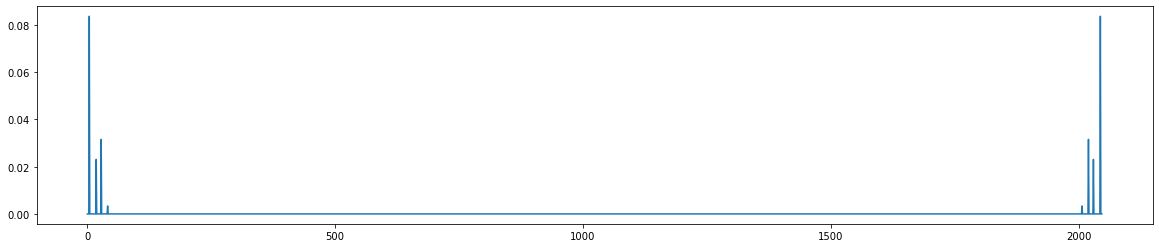

In [189]:
for ex in one_khz_examples.take(1):
    ex0 = ex
plt.figure(figsize=(20,4))
plt.plot(np.arange(len(coeffs)), np.abs(ex0[0][0,:window_size]))
plt.show()

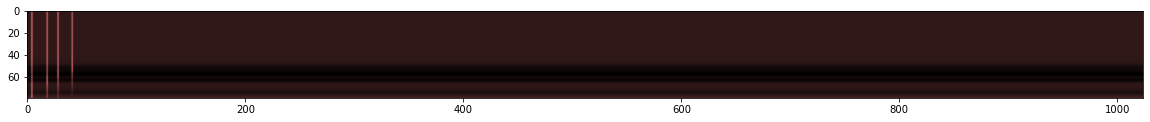

In [190]:
lpl = LoudnessPredictorLayer()
lpl.plot_snr(ex0[0][0,:window_size])

In [180]:
inputs = tf.keras.Input(shape=[window_size])
lpm = tf.keras.models.Model(inputs=inputs, outputs=lpl(inputs))
lpm.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss=LoudnessPredictorLoss())
lpm.fit(one_khz_examples, epochs=10, verbose=2)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: invalid syntax (tmp34h3oifa.py, line 17)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: invalid syntax (tmp34h3oifa.py, line 17)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: invalid syntax (tmpz71ldi8z.py, line 24)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity t

<tf.Variable 'loudness_offset:0' shape=() dtype=float32, numpy=0.13626893> <tf.Variable 'loudness_scale:0' shape=() dtype=float32, numpy=1.0050116>


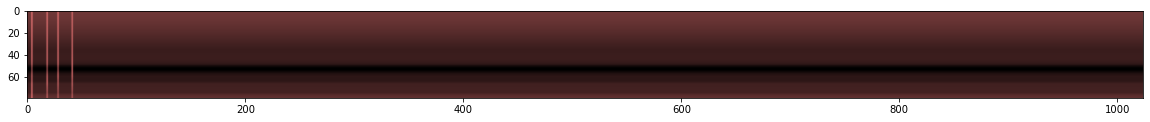

In [181]:
lpl.plot_snr(ex0[0][0,:window_size])
print(lpl._loudness_offset, lpl._loudness_scale)

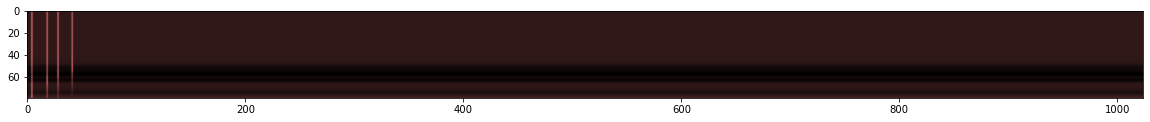

In [184]:
ear = EarSNRLayer()
ear.plot_outputs(ex0[0][0,:window_size])

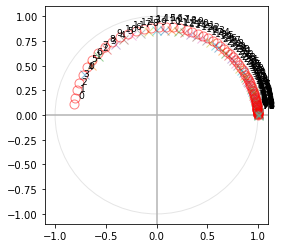

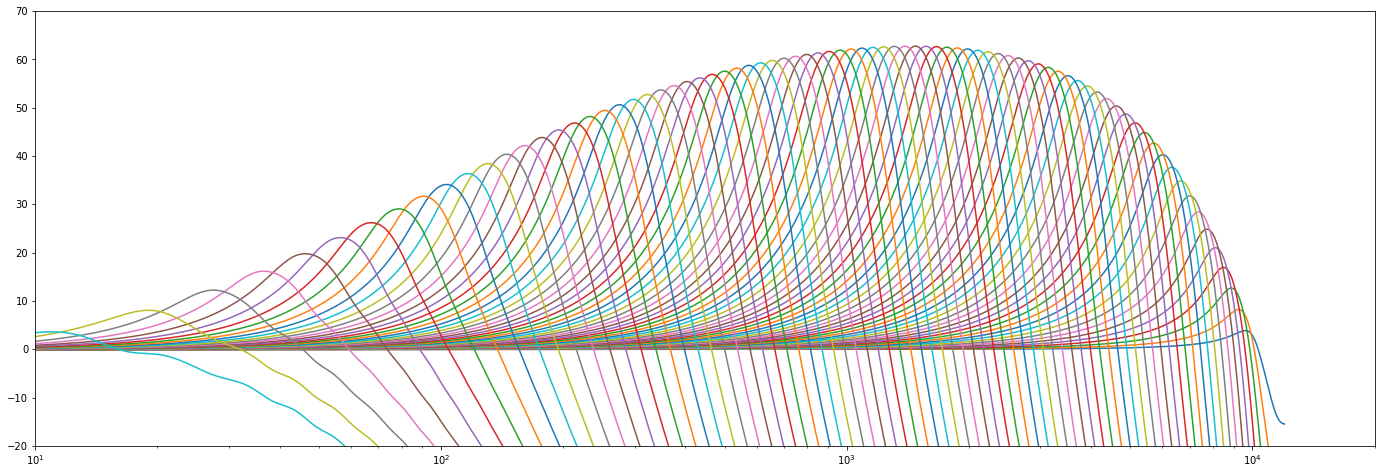

In [185]:
cl = CARLayer(erb_per_step=0.5)
cl.plot()
cl.plot_outputs(np.ones([48000], dtype=np.complex128), figsize=(24,8))

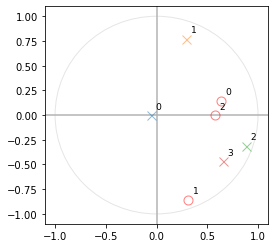

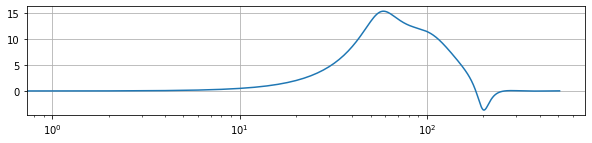

In [186]:
pz = PZLayer(
        gain=1.34,
        poles=[(-0.05429768147702485+1.4172655611120915e-05j), (0.2917622403739163+0.7731812636894612j), (0.8768382244780407-0.31120458350060115j), (0.6598943546882394-0.46728573398560225j)],
        zeros=[(0.635496172349615+0.14499945287904842j), (0.30987058966944614-0.8574194617385421j), (0.5721096307971768-2.2915816453724273e-05j)])
pz.plot()
z = np.ones([1, 1024], dtype=np.complex128)
fy = tf.math.abs(pz(z)[0])
y = 20 * np.log10(fy[:int(len(fy)/2)])
plt.figure(figsize=(10,2))
plt.xscale('log')
plt.plot(np.arange(0, len(y)), y)
plt.grid(True)
plt.show()
